In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/l4_project')
sys.path.append('/content/gdrive/My Drive/l4_project/src')

In [0]:
%cd /content/gdrive/My Drive/l4_project/src

/content/gdrive/My Drive/l4_project/src


In [0]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import load_model

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

imw = 192
imh = 192
c = 1
RS = 2211

In [0]:
from sklearn.manifold import TSNE
import umap
from keras.layers import Input, Activation, BatchNormalization, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, LeakyReLU
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [0]:
from dataset_helpers import get_label, efficient_shuffle

In [0]:
data = np.load('/content/gdrive/My Drive/l4_project/CK19_full.npz')

In [0]:
x = data['x']
filenames = data['y']

In [0]:
y = np.array([get_label(i) for i in filenames])

In [0]:
efficient_shuffle(x, random_state=RS)

## Write model

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='relu') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
from dataset_helpers import minmax

In [0]:
from segmentation import get_mask

In [0]:
idx = 0
j = 0
l = 20000
x_train = np.ndarray(shape=(l, 192, 192), dtype=np.float32)
y_train = np.ndarray(shape=(l, 192, 192), dtype=np.float32)
while idx < l:
    x_train[idx] = minmax(x[idx])
    y_train[idx] = get_mask(minmax(x_train[idx].astype(np.float32)))
    idx += 1

In [0]:
from keras.layers.merge import concatenate, add

In [0]:
input_img = Input((imw, imh, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer='adam', loss="binary_crossentropy")

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train = np.reshape(x_train, (len(x_train), 192, 192, 1))

In [0]:
y_train = np.reshape(y_train,(len(y_train), 192, 192, 1))

In [0]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=RS)

In [0]:
results = model.fit(X_train, Y_train, batch_size=32, epochs=20)



Epoch 1/20
16000/16000 [==============================] - 82s 5ms/step - loss: 0.1145
Epoch 2/20
16000/16000 [==============================] - 72s 4ms/step - loss: 0.0649
Epoch 3/20
16000/16000 [==============================] - 72s 4ms/step - loss: 0.0437
Epoch 4/20
16000/16000 [==============================] - 72s 4ms/step - loss: 0.0607
Epoch 5/20
16000/16000 [==============================] - 72s 4ms/step - loss: 0.0448
Epoch 6/20
16000/16000 [==============================] - 71s 4ms/step - loss: 0.0419
Epoch 7/20
16000/16000 [==============================] - 71s 4ms/step - loss: 0.0379
Epoch 8/20
16000/16000 [==============================] - 71s 4ms/step - loss: 0.0332
Epoch 9/20
16000/16000 [==============================] - 71s 4ms/step - loss: 0.0342
Epoch 10/20
16000/16000 [==============================] - 71s 4ms/step - loss: 0.0441
Epoch 11/20
16000/16000 [==============================] - 72s 4ms/step - loss: 0.0359
Epoch 12/20
16000/16000 [=========================

In [0]:
predictions = model.predict(X_valid)

In [0]:
from evaluation_helpers import show_image

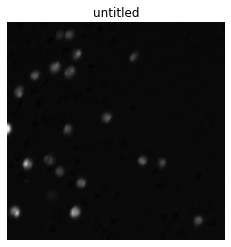

In [0]:
show_image(X_valid[159])

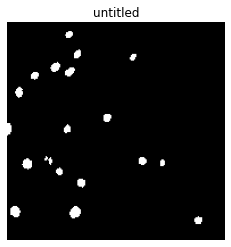

In [0]:
show_image(Y_valid[159])

In [0]:
def get_masks(images):
    unet_images = model.predict(images)
    unet_images[unet_images<0.5] = 0
    unet_images[unet_images>=0.5] = 1
    return unet_images

In [0]:
%%time
um = get_masks(X_valid[:1000])

CPU times: user 1.18 s, sys: 638 ms, total: 1.82 s
Wall time: 1.69 s


In [0]:
from segmentation import get_mask

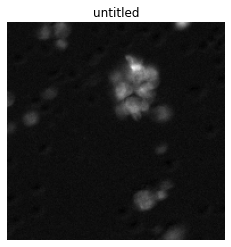

In [0]:
show_image(X_valid[169])

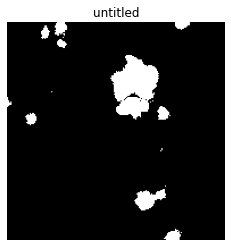

In [0]:
show_image(get_mask(X_valid[169]))

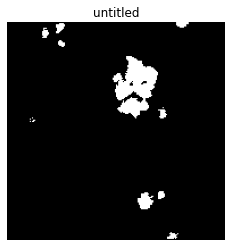

In [0]:
show_image(um[169])

In [0]:
model.save('/content/gdrive/My Drive/l4_project/unet.h5')